# GEE getThumbUrl example

In [4]:
# Import the Earth Engine Python Package
import ee

# Import Dependencies
import pandas as pd
import matplotlib.dates as mdates
from IPython.display import Image
from datetime import datetime
from matplotlib import dates
from pylab import *


import cv2 as cv


ee.Initialize()

# Initialization using polgyon

In [5]:
# set variables
SCALE = 10;
polarization = 'VV'; # vertical/vertical or vertical/horizontal

In [357]:
# build geometry to measure
rect = ee.Geometry.Polygon(
        [[106.803,-6.38],
        [106.8349,-6.38],
        [106.8349,-6.332],
        [106.803,-6.332],
        [106.803,-6.38]])

In [358]:
# convert geometry to JSON format
rect_JSON = rect.getInfo()['coordinates']

In [359]:
SCALE = 1

## run gee analysis trough api

In [360]:
# initiate google earth engine to aquire the image
S1 = ee.ImageCollection('COPERNICUS/S1_GRD')\
.filterDate('2016-01-01', '2019-12-12')\
.filter(ee.Filter.listContains('transmitterReceiverPolarisation', polarization))\
.filter(ee.Filter.eq('instrumentMode', 'IW'))\
.filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))\
.select(polarization)\
.filterBounds(rect);

In [361]:
def maskEdge(img):
    mask = img.select(0).unitScale(-25, 5).multiply(255).toByte().connectedComponents(ee.Kernel.rectangle(1,1), 100);
    return img.updateMask(mask.select(0)); 

def reproj(layer):
    layer = layer.reproject(crs ='EPSG:4326', scale = SCALE); 
    return layer;

# Get the VV collection.
Collection = ee.ImageCollection('COPERNICUS/S1_GRD')\
    .filter(ee.Filter.eq('instrumentMode', 'IW'))\
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))\
    .filterDate('2018-01-01', '2019-09-30')

Collection = Collection.map(maskEdge);

VH=Collection.select(['VH']).reduce(ee.Reducer.percentile([60])).clip(rect)
VV=Collection.select(['VV']).reduce(ee.Reducer.percentile([10])).clip(rect)

VH = reproj(VH)
total= VH.add(VV).divide(2)
total = reproj(total);

In [289]:
total_metadata = total.getInfo()

In [290]:
total_metadata

{'type': 'Image',
 'bands': [{'id': 'VH_p60',
   'data_type': {'type': 'PixelType', 'precision': 'double'},
   'dimensions': [111320, 111321],
   'origin': [11799866, 667916],
   'crs': 'EPSG:4326',
   'crs_transform': [8.983152841195214e-06,
    0.0,
    0.0,
    0.0,
    -8.983152841195214e-06,
    0.0]}]}

# Plotting the result

In [362]:
# visualize resulting image
url = S1.first().getThumbUrl({
    'region':rect_JSON,
    'min':-20,
    'max':-5,
    'palette':['0784b5', '39ace7', '9bd4e4', 'cadeef', 'ffffff']
})

In [363]:
url

'https://earthengine.googleapis.com/api/thumb?thumbid=60c718f48e10e375d5fcd5760530b00d&token=ce1d0788c5fd523f11246703330e5d11'

In [321]:
from skimage import io

In [364]:
SAR_img = io.imread(url)

In [365]:
rect_geom = rect.getInfo()

In [407]:
x_min = rect_geom['coordinates'][0][0][0]
x_max = rect_geom['coordinates'][0][1][0]

y_min = rect_geom['coordinates'][0][1][1]
y_max = rect_geom['coordinates'][0][3][1]

d_y = (y_max - y_min)

d_x = (x_max - x_min)

In [408]:
deg_pix_x_SAR = d_x / SAR_img.shape[1]

deg_pix_y_SAR = d_y / SAR_img.shape[0]

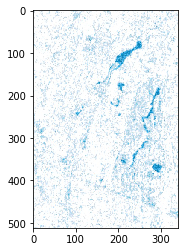

In [388]:
plt.imshow(SAR_img)

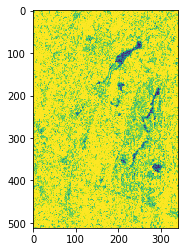

In [389]:
array_SAR_img = SAR_img[:,:,1]
plt.imshow(array_SAR_img)

In [226]:
from gbdxtools.task import env
from gbdxtools import Interface, CatalogImage
gbdx = Interface()

%matplotlib inline

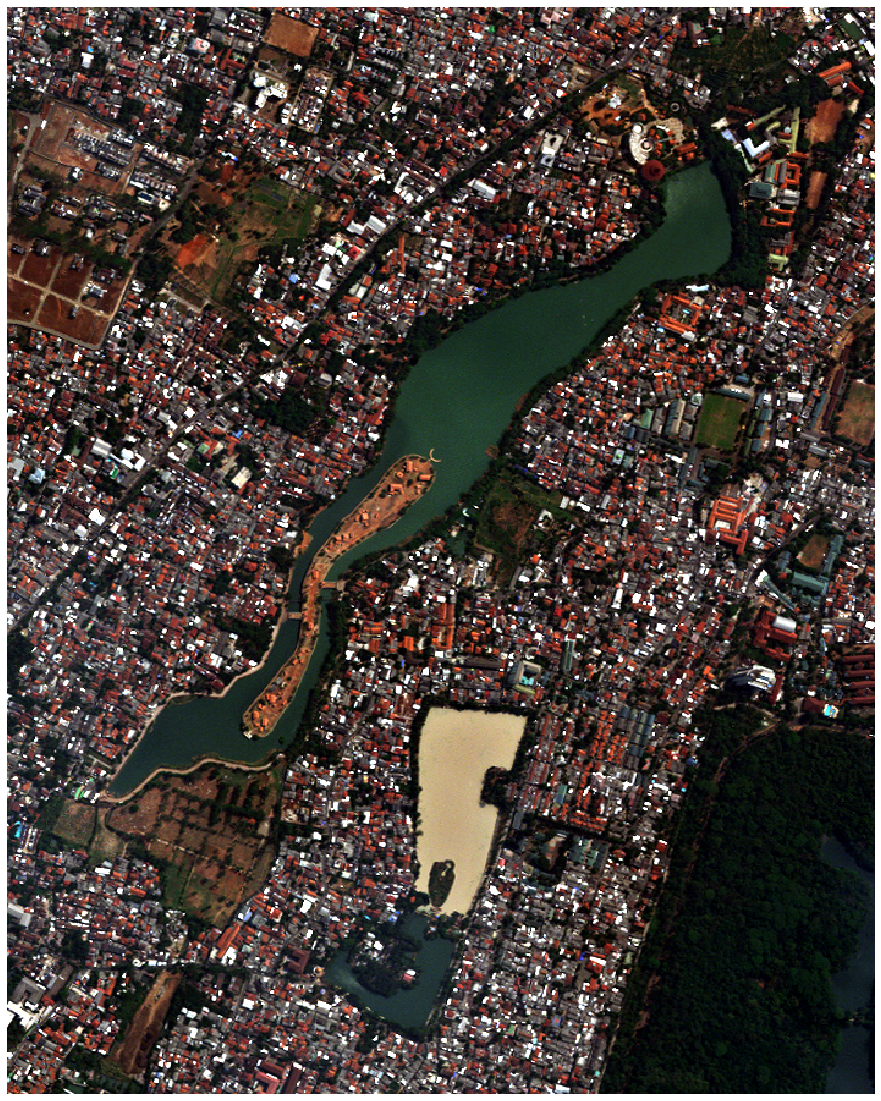

In [381]:
catalog_id = env.inputs.get('catalog_id', '10300100990D7100')
bbox = env.inputs.get('bbox', '106.81431770324708, -6.354539572214886, 106.82916641235353, -6.335943106381095')

WV_img = CatalogImage(catalog_id, band_type="MS", 
                      bbox=map(float, bbox.split(",")), 
                      acomp=True, 
                      proj = 'EPSG:4326')

WV_img.plot(w=20, h=20) 

In [159]:
# get bands 
coastal = WV_img[0,:,:].astype(np.float32)
nir1 = WV_img[6,:,:].astype(np.float32)
nir2 = WV_img[7,:,:].astype(np.float32)
red = WV_img[4,:,:].astype(np.float32)


# perform index calculations 
avg = (nir1+nir2)/2
water_index = (coastal - avg)/(coastal + avg)
ndvi = (nir1 - red)/(nir1 +red)

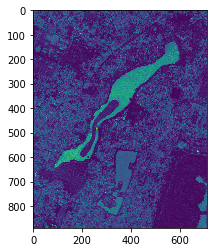

In [160]:
plt.imshow(water_index)

In [161]:
array_water_index = water_index.compute()

In [162]:
OldRange = (array_water_index.max() - array_water_index.min())  
NewRange = (0 - 255)  
NewValue = (((array_water_index - array_water_index.min()) * NewRange) / OldRange) + 0

In [163]:
array_water_index_int = NewValue.round().astype(uint8)

# apply guassian blur on src image
array_water_index_int = cv.GaussianBlur(array_water_index_int,(21,21),cv.BORDER_DEFAULT)

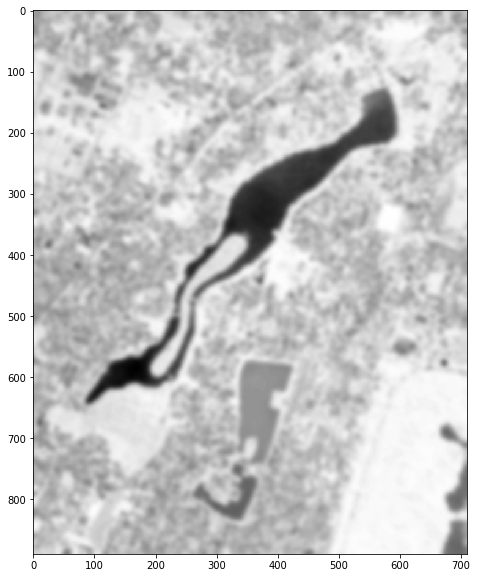

In [164]:
fig, ax = subplots(figsize=(18, 10))
ec = ax.imshow(array_water_index_int, cmap='gray')
# cbar = plt.colorbar(ec)
# cbar.set_label('values')


In [390]:
x_s_WV = array_water_index_int.shape[1]

In [391]:
d_x_WV = (float(bbox.split(",")[2]) - float(bbox.split(",")[0]))

deg_pix_WV = d_x_WV / x_s_WV 


devide_WV =  deg_pix_WV / deg_pix_SAR

In [392]:
img1 = array_SAR_img
 
img2 = array_water_index_int

In [393]:
# get ratios

fraction = devide_WV

x = int(round(img2.shape[0] * fraction, 0 ))

y = int(round(img2.shape[1] * fraction, 0 ))

# match features (no success)

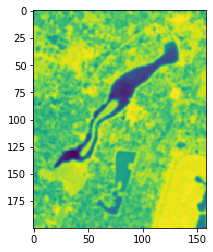

In [394]:


img2 = cv.resize(array_water_index_int, dsize=(y, x), interpolation=cv.INTER_CUBIC)

plt.imshow(img2)


In [395]:


# Initiate ORB detector
orb = cv.ORB_create()
# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)

kp2, des2 = orb.detectAndCompute(img2,None)

In [396]:
# create BFMatcher object
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
# Match descriptors.
matches = bf.match(des1,des2)
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)
# Draw first 10 matches.
img3 = cv.drawMatches(img1,kp1,img2,kp2,matches[:100],None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

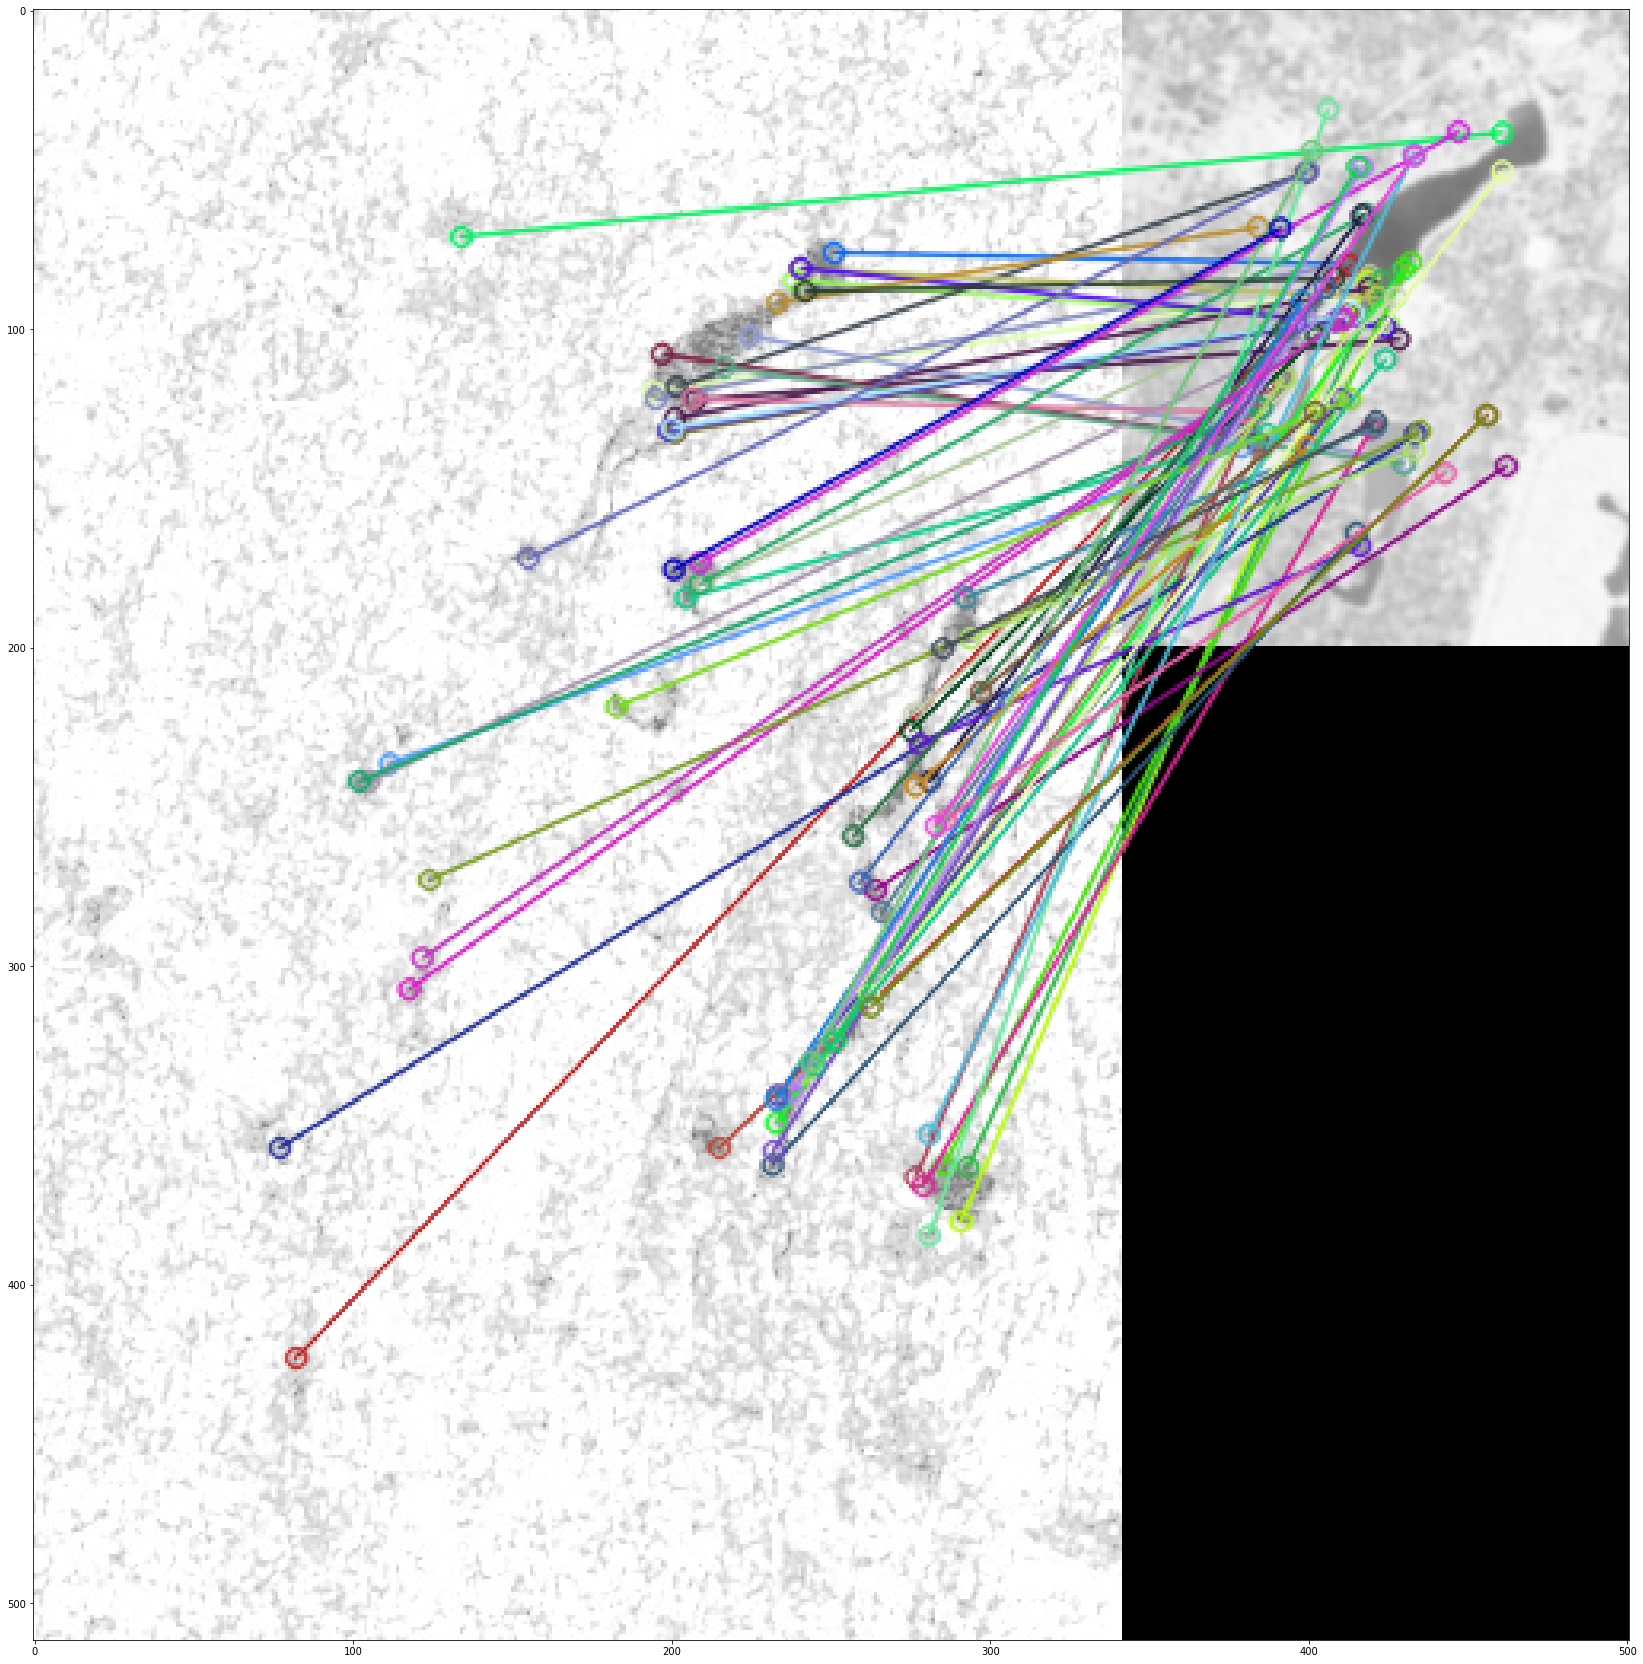

(<matplotlib.image.AxesImage at 0x7f39d893afd0>, None)

In [397]:

fig, ax = subplots(figsize=(30, 30))
ax.imshow(img3),plt.show()

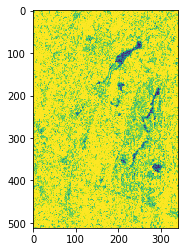

In [398]:
plt.imshow(img1)

# Template matching


In [426]:
import numpy as np

gray_image = img1
img_gray = img1
main_image = img1

template = img2


from PIL import Image

width, height = template.shape[::-1] #get the width and height

match = cv.matchTemplate(gray_image, template, cv.TM_CCOEFF_NORMED)
max_value = match.max()
position = np.where(match == max_value)

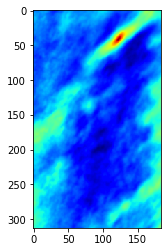

In [435]:
plt.imshow(match, cmap = "jet")

In [439]:
# save one image
import matplotlib.pyplot as plt
import datetime
NOW = datetime.datetime.now()


fig, ax = plt.subplots(1,figsize=(100,100))
plt.imshow(match, cmap = "jet")#, vmin=-1, vmax=1,) # edit this to plot another raster
fig.savefig('Template_matching_setu_babakan_{}.png'.format(NOW),
            bbox_inches='tight')
plt.close(fig)    # close the figure

In [428]:
position

(array([41]), array([123]))

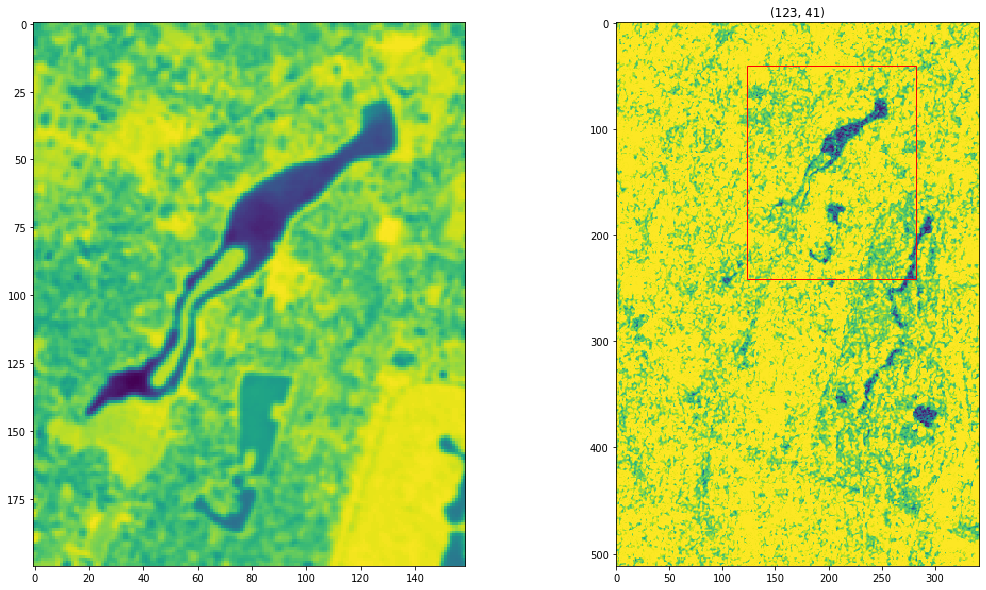

In [432]:
fig, ax = subplots(1,2,figsize=(18, 10))

ax[0].imshow(img2)
ax[1].imshow(img1)

# Create a Rectangle patch
rect = matplotlib.patches.Rectangle((position[1],position[0]),width,height,linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax[1].add_patch(rect)

ax[1].set_title((int(position[1]),int(position[0])))

plt.show()

In [433]:
x_SAR = float((position[1] * deg_pix_x_SAR) + x_min)

y_SAR = float((position[0] * deg_pix_y_SAR) + y_min)

In [434]:
x_SAR - 106.81431770324708, y_SAR - -6.354539572214886

(0.00015510377045302448, -0.021616677785114113)

In [ ]:
xmin,ymin,xmax,ymax = [lon.min(),lat.min(),lon.max(),lat.max()]
nrows,ncols = np.shape(array)
xres = (xmax-xmin)/float(ncols)
yres = (ymax-ymin)/float(nrows)
geotransform=(xmin,xres,0,ymax,0, -yres)   
# That's (top left x, w-e pixel resolution, rotation (0 if North is up), 
#         top left y, rotation (0 if North is up), n-s pixel resolution)
# I don't know why rotation is in twice???

output_raster = gdal.GetDriverByName('GTiff').Create('myraster.tif',ncols, nrows, 1 ,gdal.GDT_Float32)  # Open the file
output_raster.SetGeoTransform(geotransform)  # Specify its coordinates
srs = osr.SpatialReference()                 # Establish its coordinate encoding
srs.ImportFromEPSG(4326)                     # This one specifies WGS84 lat long.
                                             # Anyone know how to specify the 
                                             # IAU2000:49900 Mars encoding?
output_raster.SetProjection( srs.ExportToWkt() )   # Exports the coordinate system 
                                                   # to the file
output_raster.GetRasterBand(1).WriteArray(array)   # Writes my array to the raster

output_raster.FlushCache()

# using PIL

In [46]:
from PIL import Image

# Convert array to Image
array_water_index_int_PIL = Image.fromarray(array_water_index_int)

array_water_index_int_PIL_match = array_water_index_int_PIL.resize((array_SAR_img.shape[1],array_SAR_img.shape[0]))

#img1 = np.array(array_water_index_int_PIL_match).astype(uint8)

array_water_index_int_PIL_match